In [ ]:
#!pip install tensorflow==2.15

In [1]:
%cd /content

/content


In [2]:
from PIL import Image
import dask.dataframe as dd
import os
import pydicom as dicom

In [3]:
from tensorflow import keras

from keras import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Conv3D, Conv2D, MaxPooling3D
from keras.utils import to_categorical
import pandas as pd
import numpy as np
# import nessesary libs

# Classification

In [4]:
#Function to create an array of pixels given the image path

def path_to_pixels(image_path):
    try:
      ds = dicom.dcmread(image_path).pixel_array
    except:
      num_not_exist_images+=1
      return
    #reducing the depth because we don't have enough memory
    target_shape = (25, 256, 256, 1)

    # Calculate the required padding for each dimension
    #If the image is 2d (no depth)
    if(len(ds.shape)<=2):
      pad_depth = target_shape[0]-1
      pad_rows = target_shape[1] - ds.shape[0]
      pad_cols = target_shape[2] - ds.shape[1]

      # Reshape the image to be 3D so that it can be padded later
      ds = ds.reshape(1, ds.shape[0], ds.shape[1])

    else:
      pad_depth = target_shape[0] - ds.shape[0]
      pad_rows = target_shape[1] - ds.shape[1]
      pad_cols = target_shape[2] - ds.shape[2]

    #If depth is greater than that of target_shape, truncate
    if pad_depth<0:
      pad_depth = 0
      ds = ds[:target_shape[0]]

    #If width is greater than that of target_shape, truncate
    if pad_rows<0:
      pad_rows = 0
      ds = ds[:, :target_shape[1]]

    #If height is greater than that of target_shape, truncate
    if pad_cols<0:
      pad_cols = 0
      ds = ds[:, :, :target_shape[2]]

    # Apply zero padding
    padded_array = np.pad(ds, ((0, pad_depth), (0, pad_rows), (0, pad_cols)), mode='constant')
    return padded_array.reshape(target_shape)

In [5]:
num_not_exist_images=0

In [6]:
#Function retaining only 2d images - just to check performance
#This will have to be changed in the future - here we are ignoring all 3D images

def path_to_pixels_2d(image_path):
    try:
      ds = dicom.dcmread(image_path).pixel_array
    except:
      #num_not_exist_images+=1
      return
    target_shape = (256, 256, 1)

    # Calculate the required padding for each dimension
    #If the image is 2d (no depth)
    if(len(ds.shape)>2):
      return

    pad_rows = target_shape[0] - ds.shape[0]
    pad_cols = target_shape[1] - ds.shape[1]


    #If width is greater than that of target_shape, ~truncate~ ignore
    if pad_rows<0:
    #   pad_rows = 0
    #   ds = ds[:target_shape[0]]
      return

    #If height is greater than that of target_shape, ~truncate~ ignore
    if pad_cols<0:
      # pad_cols = 0
      # ds = ds[:, :target_shape[1]]
      return

    # Apply zero padding
    padded_array = np.pad(ds, ((0, pad_rows), (0, pad_cols)), mode='constant')
    return padded_array.reshape(target_shape)

In [7]:
#Function to generate batches

def generate_batches(data):
  np.random.seed(32) # for reproducible results.

  num_partitions = 1000

  #Creating num_partitions partitions
  for i in range(num_partitions):
      df = np.array_split(data.reindex(np.random.permutation(data.index)),num_partitions)[i]
      df['pixels'] = df['absolute_paths'].map(path_to_pixels_2d)
      df = df.dropna()
      X = df['pixels']
      X = np.stack(X.array)
      y = np.array(df['numeric_labels'], dtype=np.float32)
      #y = to_categorical(y)
      yield X, y

## GPU Information

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
  #For GPU tunning

Mon Apr 22 23:32:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')
  #FOR ram tunning

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Dataset Pre-processing

In [ ]:
#Reading original data

data = pd.read_csv('labeled_data.csv')

In [ ]:
data

,Unnamed: 0,Subject,File Name,Group
0,0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
1,1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
2,2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
3,3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
4,4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
...,...,...,...,...
455021,455021,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...,PD
455022,455022,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...,PD
455023,455023,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...,PD
455024,455024,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...,PD


In [ ]:
#Finding the absolute paths for each image

absolute_paths = []
for subj_id in os.listdir('./PPMI'):
  for imaging_method in os.listdir(os.path.join('./PPMI', subj_id)):
    for date in os.listdir(os.path.join('./PPMI', subj_id, imaging_method)):
      for im_id in os.listdir(os.path.join('./PPMI', subj_id, imaging_method, date)):
        for image_name in os.listdir(os.path.join('./PPMI', subj_id, imaging_method, date, im_id)):
          absolute_paths.append(os.path.join('./PPMI', subj_id, imaging_method, date, im_id, image_name))

In [ ]:
#Adding absolute paths to the dataframe

data['absolute_paths'] = absolute_paths

In [ ]:
def labels_to_numeric(y):
  if y=='PD':
    return 0
  elif y=='Prodromal':
    return 1
  else:
    return 2

In [ ]:
data['numeric_labels'] = data['Group'].map(labels_to_numeric)

In [ ]:
data.tail(40)

In [ ]:
data.to_csv('data.csv')

## Visualization

(46, 64, 64)
(46, 64, 40)


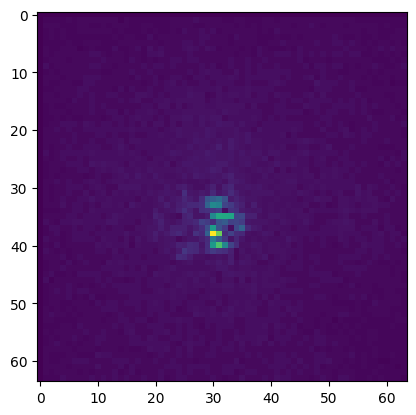

In [ ]:
#Code blocks to visualize particular images, and for testing purposes

#y = dicom.dcmread(data['absolute_paths'][100])
x = dicom.dcmread('./PPMI/204011/Split_from_rsfMRI_RL/2023-03-07_13_30_07.0/I1703502/PPMI_204011_MR_Split_from_rsfMRI_RL_br_raw_20230518003607491_145_S1225535_I1703502.dcm').pixel_array
print(x.shape)
print(x[:, :, :40].shape)
plt.imshow(x[45])

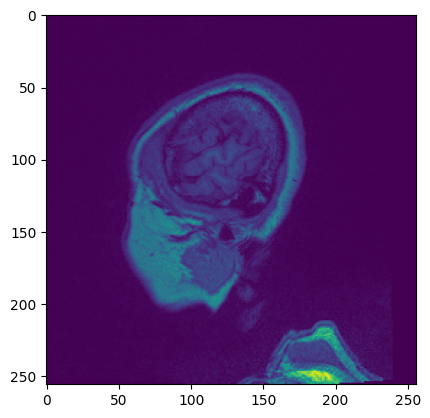

In [ ]:
#Testing image padding

target_shape = (256, 256)

# Calculate the required padding for each dimension
pad_rows = target_shape[0] - x.shape[0]
pad_cols = target_shape[1] - x.shape[1]

# Apply zero padding
padded_array = np.pad(x, ((0, pad_rows), (0, pad_cols)), mode='constant')
pa = padded_array.reshape(256, 256, 1)
#plt.imshow(padded_array)
plt.imshow(pa)

In [ ]:
#Converting to greyscale

# r, c = x.shape

# new = np.empty((r, c, 3), dtype=x.dtype)

# new[:,:,2] = new[:,:,1] = new[:,:,0] = x
# # or with broadcasting
# new[:,:,:] = x[:,:, np.newaxis]

# print(new.shape)
# plt.imshow(new)

## Training

In [10]:
#Reading the data

data = pd.read_csv('data.csv')

In [11]:
#data1 = pd.read_csv('data1.csv')

In [12]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Subject,File Name,Group,absolute_paths,numeric_labels
0,0,0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI/3770/Axial_PD-T2_TSE/2012-02-08_10_16_1...,0
1,1,1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI/3770/Axial_PD-T2_TSE/2012-02-08_10_16_1...,0
2,2,2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI/3770/Axial_PD-T2_TSE/2012-02-08_10_16_1...,0
3,3,3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI/3770/Axial_PD-T2_TSE/2012-02-08_10_16_1...,0
4,4,4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI/3770/Axial_PD-T2_TSE/2012-02-08_10_16_1...,0


In [13]:
data.shape

(455026, 7)

In [14]:
#data1.shape

In [15]:
#Creating the model

import keras
from keras import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf


width = 256
height = 256
depth = 25
num_examples = data.shape[0]

# -- Preparatory code --
# Model configuration
batch_size = 1
no_classes = 3    #for parkinson, prodromal, and control
verbosity = 1

learning_rate = 0.001
weight_decay = 0.0001


strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


print("Started")
#========================================================================================
# CNN model

with strategy.scope():

  model = Sequential()


  # model.add(Conv3D(filters=64, kernel_size=3, activation="relu",input_shape=(depth, width,height,1)))
  # model.add(MaxPooling3D(pool_size=2))
  # model.add(BatchNormalization())

  # model.add(Conv3D(filters=64, kernel_size=3, activation="relu"))
  # model.add(MaxPooling3D(pool_size=2))
  # model.add(BatchNormalization())

  # model.add(Conv3D(filters=64, kernel_size=3, activation="relu"))
  # model.add(MaxPooling3D(pool_size=2))
  # model.add(BatchNormalization())

  # model.add(Conv3D(filters=64, kernel_size=3, activation="relu"))
  # model.add(MaxPooling3D(pool_size=2))
  # model.add(BatchNormalization())


  #2D CNN

  model.add(Conv2D(filters=16, kernel_size=3, activation="relu",input_shape=(width,height,1)))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())


  # Passing it to a Fully Connected layer
  model.add(Flatten())



  # 2nd Fully Connected Layer
  model.add(Dense(500))
  model.add(Activation('relu'))
  # Add Dropout


  # 3rd Fully Connected Layer
  model.add(Dense(500))
  model.add(Activation('relu'))
  # Add Dropout



  # Output Layer
  model.add(Dense(3))
  model.add(Activation('softmax'))

#   optimizer = keras.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     )

#   model.compile(
#     optimizer=optimizer,
#     loss=keras.losses.SparseCategoricalCrossentropy(),
#     metrics=[
#        "accuracy"
#     ],
# )
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.summary()



Number of devices: 2
Started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                           

In [16]:
%cd /content/disk2/

/content/disk2


In [17]:
%pwd

'/content/disk2'

In [18]:
# Training (in batches)

# We have ignored 3d images (no depth images used)

epochs = 5
for epoch in range(epochs):
  print("Epoch:", epoch)
  count = 0
  for x_batch, y_batch in generate_batches(data):
    count+=1
    history = model.train_on_batch(
        x_batch,
        y_batch
        )
    if count%100 == 0 and count !=0:
      print(count, " batches processed")
      print(history)

Epoch: 0
100  batches processed
[0.6769825220108032, 0.7004608511924744]
200  batches processed
[0.6768869757652283, 0.7247706651687622]
300  batches processed
[0.4083794057369232, 0.8360277414321899]
400  batches processed
[0.3168279528617859, 0.875]
500  batches processed
[0.2847394347190857, 0.8732718825340271]
600  batches processed
[0.250836580991745, 0.8906976580619812]
700  batches processed
[0.17746149003505707, 0.9300699234008789]
800  batches processed
[0.17747436463832855, 0.9178403615951538]
900  batches processed
[0.1534927487373352, 0.9373549818992615]
1000  batches processed
[0.14796459674835205, 0.9458823800086975]
Epoch: 1
100  batches processed
[0.16613776981830597, 0.940092146396637]
200  batches processed
[0.1337357461452484, 0.9449541568756104]
300  batches processed
[0.12536980211734772, 0.9468821883201599]
400  batches processed
[0.08089084178209305, 0.9699074029922485]
500  batches processed
[0.08262322843074799, 0.9631336331367493]
600  batches processed
[0.075

KeyboardInterrupt: 

In [19]:
model.save('../model_1_a.model')

In [20]:
print(history)

[0.033691711723804474, 0.9883449673652649]


In [23]:
%cd /content

/content


In [24]:
%pwd

'/content'

In [ ]:
# Continuing the training on new data

trained_model = keras.saving.load_model('model_1_a.model')
epochs = 2
for epoch in range(epochs):
  print("Epoch:", epoch)
  count = 0
  for x_batch, y_batch in generate_batches(data1):
    count+=1
    history = trained_model.train_on_batch(
        x_batch,
        y_batch
        )
    if count%50 == 0 and count !=0:
      print(count, " batches processed")
      print(history)

Epoch: 0
50  batches processed
0.742044985294342
100  batches processed
0.5455434918403625
150  batches processed
0.3455696702003479
200  batches processed
0.21626466512680054
250  batches processed
0.18895788490772247
300  batches processed
0.19833624362945557
350  batches processed
0.14432743191719055
400  batches processed
0.11491519957780838
450  batches processed
0.13137809932231903
500  batches processed
0.09062463045120239
550  batches processed
0.09163300693035126
600  batches processed
0.21064428985118866
650  batches processed
0.05123606696724892
700  batches processed
0.07330836355686188
750  batches processed
0.08176242560148239
800  batches processed
0.05343620479106903
Epoch: 1
50  batches processed
0.12046697735786438
100  batches processed
0.07403451949357986
150  batches processed
0.03752002492547035
200  batches processed
0.05701412260532379
250  batches processed
0.0634746104478836
300  batches processed
0.03427419438958168
350  batches processed
0.04282744601368904


In [ ]:
trained_model.save('model_1_b.model')

In [ ]:
print(history)

0.06295810639858246


## Testing

### Dataset Pre-processing

In [25]:
#Reading original data

test_data = pd.read_csv('test_labeled_data.csv')

In [26]:
#Finding the absolute paths for each image
absolute_paths = []
for subj_id in os.listdir('./PPMI_test'):
  for imaging_method in os.listdir(os.path.join('./PPMI_test', subj_id)):
    for date in os.listdir(os.path.join('./PPMI_test', subj_id, imaging_method)):
      for im_id in os.listdir(os.path.join('./PPMI_test', subj_id, imaging_method, date)):
        for image_name in os.listdir(os.path.join('./PPMI_test', subj_id, imaging_method, date, im_id)):
          absolute_paths.append(os.path.join('./PPMI_test', subj_id, imaging_method, date, im_id, image_name))

In [27]:
#Adding absolute paths to the dataframe

test_data['absolute_paths'] = absolute_paths

In [28]:
def labels_to_numeric(y):
  if y=='PD':
    return 0
  elif y=='Prodromal':
    return 1
  else:
    return 2

In [29]:
test_data['numeric_labels'] = test_data['Group'].map(labels_to_numeric)

In [30]:
test_data.to_csv('test_data.csv')

### Testing

In [31]:
#Reading the data

test_data = pd.read_csv('test_data.csv')

In [32]:
test_data.head()

,Unnamed: 0.1,Unnamed: 0,Subject,File Name,Group,absolute_paths,numeric_labels
0,0,0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI_test/3770/Axial_PD-T2_TSE/2012-02-08_10...,0
1,1,1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI_test/3770/Axial_PD-T2_TSE/2012-02-08_10...,0
2,2,2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI_test/3770/Axial_PD-T2_TSE/2012-02-08_10...,0
3,3,3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI_test/3770/Axial_PD-T2_TSE/2012-02-08_10...,0
4,4,4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD,./PPMI_test/3770/Axial_PD-T2_TSE/2012-02-08_10...,0


In [34]:
trained_model = keras.saving.load_model('model_1_a.model')

for test_X, test_y in generate_batches(test_data):
  history = trained_model.test_on_batch(test_X, test_y)

KeyboardInterrupt: 

In [36]:
print(history)

[1.838395118713379, 0.5337995290756226]


In [35]:
preds = trained_model.predict(test_X)
preds = [np.argmax(i, axis=-1) for i in preds]
np.sum(preds==test_y)/len(preds)

14/14 [==============================] - 1s 27ms/step


0.5337995337995338

In [ ]:
trained_model = keras.saving.load_model('model_1_b.model')

for test_X, test_y in generate_batches(test_data):
  trained_model.evaluate(test_X, test_y)
  break

4/4 [==============================] - 0s 16ms/step - loss: 1.0267


In [ ]:
preds = trained_model.predict(test_X)

4/4 [==============================] - 0s 14ms/step


In [ ]:
preds = [np.argmax(i, axis=-1) for i in preds]
np.sum(preds==test_y)/len(preds)

0.2

## Evaluation

In [ ]:
from numpy import argmax
model.compile(loss='mse', optimizer='adam')
print("model compiled")

from sklearn import metrics
from sklearn.model_selection import KFold

tx,*_=np.shape(X_all)
Y_Pred_all = np.zeros(tx)
seed = 7
fold=10
np.random.seed(seed)
kfold = KFold(n_splits=fold, shuffle = True, random_state = seed)
#Arrengement for K fold
batch_size = 4
no_epochs = 30
no_classes = 2    #for parkinson and control
verbosity = 1
learning_rate = 0.0001

count = 1
for train, test in kfold.split(X_all,Y_all):
    print(np.shape(X_all[train]))
    print(np.shape(Y_all[train]))
    print(count,". Fold")
    count +=1
    history = model.fit(X_all[train], Y_all[train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbosity)
    Y_Pred = model.predict(X_all[test])
  #model predicting

    Y_Pred = argmax(Y_Pred, axis=1)
    j = 0
    for i in test:
      Y_Pred_all[i] = Y_Pred[j]
      j+=1


In [ ]:
Y_True = Y_temp

#for evaluating
import sklearn.metrics as metrics
acc = metrics.accuracy_score(Y_True, Y_Pred_all, normalize=True)
f1 = metrics.f1_score(Y_True,Y_Pred_all, average=None)
roc_auc = metrics.roc_auc_score(Y_True,Y_Pred_all)
precision = metrics.precision_score(Y_True,Y_Pred_all, average=None)
recall = metrics.recall_score(Y_True,Y_Pred_all, average=None)
confusion = metrics.confusion_matrix(Y_True,Y_Pred_all)

print("Accuracy:  "+str(acc))
print("Roc_auc:  "+str(roc_auc))
print("F1:  "+str(f1))
print("Precision:  "+str(precision))
print("Recall:  "+str(recall))
print("Confusion:  "+str(confusion))